In [38]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [39]:
spx = pd.read_csv('data/^spx/history/^spx.csv')
apple = pd.read_csv('data/^spx/history/AAPL.csv')
yield_curve = pd.read_csv('data/yield-curve-rates-1990-2021.csv')
yearly_inflation = pd.read_csv('data/yearly_us_inflation.csv', sep=',')

In [40]:
yearly_inflation['inflation'] = yearly_inflation['inflation'].str.replace(",", ".").astype(float)
yearly_inflation['year'] = yearly_inflation['year'].astype(int)
yearly_inflation.head()

,year,inflation
0,1960,1.457976
1,1961,1.070724
2,1962,1.198773
3,1963,1.239669
4,1964,1.278912


In [41]:
yield_curve['date'] = pd.to_datetime(yield_curve['Date']).dt.date
yield_curve.head()

/tmp/ipykernel_8333/1579587904.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  yield_curve['date'] = pd.to_datetime(yield_curve['Date']).dt.date


,Date,1 Mo,2 Mo,3 Mo,4 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr,date
0,12/31/21,0.06,0.05,0.06,NaN,0.19,0.39,0.73,0.97,1.26,1.44,1.52,1.94,1.90,2021-12-31
1,12/30/21,0.06,0.06,0.05,NaN,0.19,0.38,0.73,0.98,1.27,1.44,1.52,1.97,1.93,2021-12-30
2,12/29/21,0.01,0.02,0.05,NaN,0.19,0.38,0.75,0.99,1.29,1.47,1.55,2.00,1.96,2021-12-29
3,12/28/21,0.03,0.04,0.06,NaN,0.20,0.39,0.74,0.99,1.27,1.41,1.49,1.94,1.90,2021-12-28
4,12/27/21,0.04,0.05,0.06,NaN,0.21,0.33,0.76,0.98,1.26,1.41,1.48,1.92,1.88,2021-12-27


In [42]:
apple.head()

,Data,Otwarcie,Najwyzszy,Najnizszy,Zamkniecie,Wolumen
0,1984-09-07,0.100763,0.101999,0.099546,0.100763,9.767604e+07
1,1984-09-10,0.100763,0.101071,0.098340,0.100165,7.581254e+07
2,1984-09-11,0.101071,0.103814,0.101071,0.101999,1.787705e+08
3,1984-09-12,0.101999,0.102597,0.098928,0.098928,1.561713e+08
4,1984-09-13,0.104432,0.104730,0.104432,0.104432,2.432310e+08


In [43]:
apple['date'] = pd.to_datetime(apple['Data']).dt.date
apple['value'] = apple['Otwarcie']

spx['date'] = pd.to_datetime(spx['Data']).dt.date
spx['value'] = spx['Otwarcie']

df = spx[['date', 'value']].merge(apple[['date', 'value']], on='date', suffixes=('_spx',  '_appl'))
df = df.merge(yield_curve[['date', '5 Yr']], on='date')
df['year'] = pd.to_datetime(df['date']).dt.year.astype(int)

df = df.merge(yearly_inflation, on='year')

df.head()

,date,value_spx,value_appl,5 Yr,year,inflation
0,1990-01-02,353.40,0.268232,7.87,1990,5.397956
1,1990-01-03,359.69,0.289238,7.92,1990,5.397956
2,1990-01-04,358.76,0.290992,7.91,1990,5.397956
3,1990-01-05,355.67,0.287383,7.92,1990,5.397956
4,1990-01-08,352.20,0.285569,7.92,1990,5.397956


In [44]:
df.head()

,date,value_spx,value_appl,5 Yr,year,inflation
0,1990-01-02,353.40,0.268232,7.87,1990,5.397956
1,1990-01-03,359.69,0.289238,7.92,1990,5.397956
2,1990-01-04,358.76,0.290992,7.91,1990,5.397956
3,1990-01-05,355.67,0.287383,7.92,1990,5.397956
4,1990-01-08,352.20,0.285569,7.92,1990,5.397956


In [45]:
spx_shift = df['value_spx'].shift(periods=365)
appl_shift = df['value_appl'].shift(periods=365)

df['risk_free_return'] = df['5 Yr'] - df['inflation']
df['spx_yearly_return'] = (df['value_spx'] - spx_shift) / spx_shift
df['appl_yearly_return'] = (df['value_appl'] - appl_shift) / appl_shift
df['excess_return'] = df['appl_yearly_return'] - df['risk_free_return']

In [46]:
def eval_beta(df, window, stock='appl_yearly_return', market='spx_yearly_return'):
    cov = df[[stock, market]].rolling(window).cov()
    return cov.xs(market, level=1)[stock] / cov.xs(market, level=1)[market]


df['beta_official_60'] = eval_beta(df, 365 * 5)
df['beta_official_30'] = eval_beta(df, int(365 * 2.5))
df['beta_official_12'] = eval_beta(df, 365)

/tmp/ipykernel_8333/2437770743.py:23: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.get_shared_x_axes().join(ax, ax2)


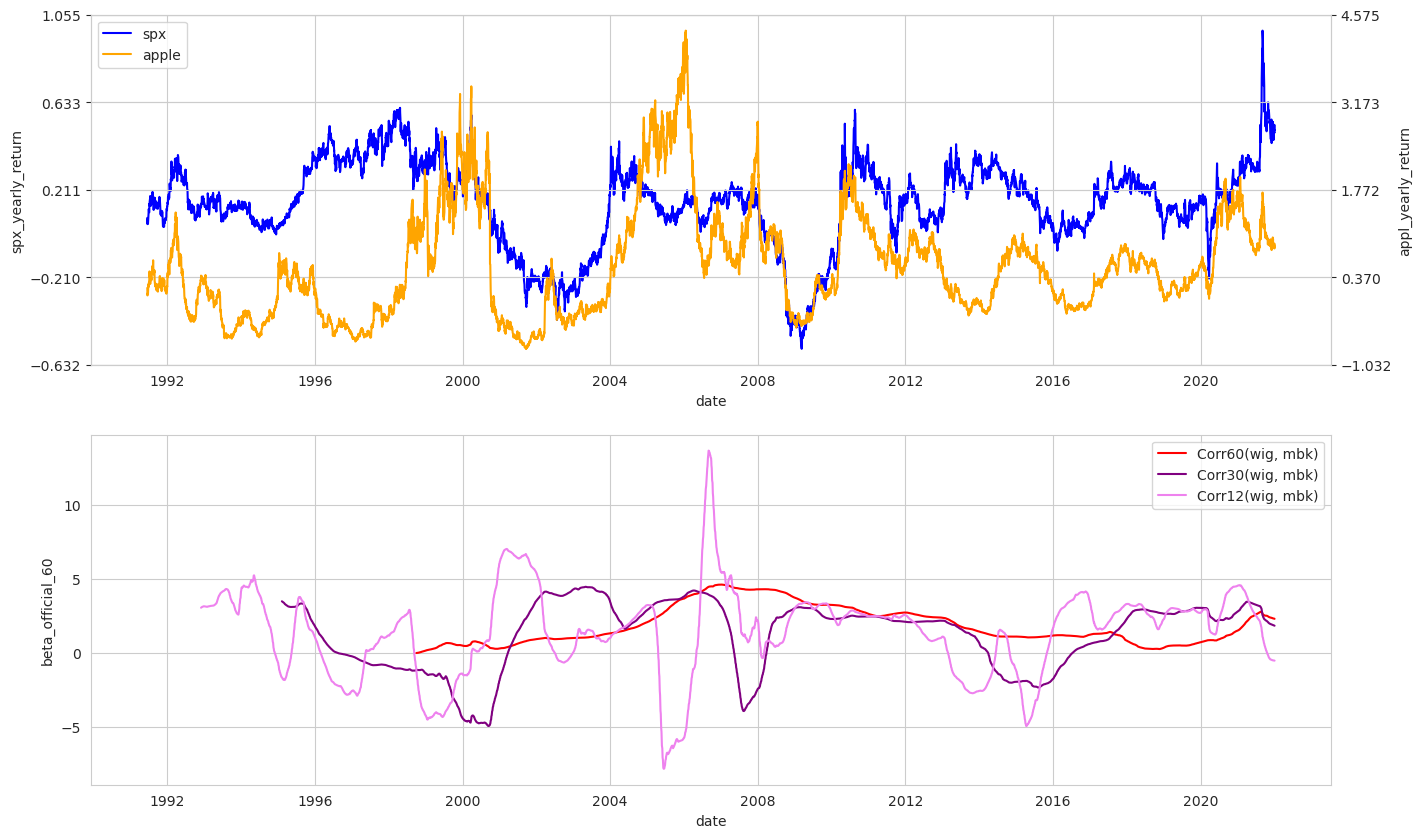

In [47]:
fig, (ax, ax2) = plt.subplots(nrows=2)

twinx = ax.twinx()

sns.lineplot(df, x='date', y='spx_yearly_return', label='spx', color='blue', ax=ax)
sns.lineplot(df, x='date', y='appl_yearly_return', label='apple', color='orange', ax=twinx)

ax_handles, ax_labels = ax.get_legend_handles_labels()
tx_handles, tx_labels = twinx.get_legend_handles_labels()
ax.legend(ax_handles + tx_handles, ax_labels + tx_labels)
twinx.get_legend().remove()

ax.set_yticks(np.linspace(ax.get_ybound()[0], ax.get_ybound()[1], 5))
twinx.set_yticks(np.linspace(twinx.get_ybound()[0], twinx.get_ybound()[1], 5))

sns.lineplot(df, x='date', y='beta_official_60', label='Corr60(wig, mbk)',
             color='red', ax=ax2)
sns.lineplot(df, x='date', y='beta_official_30', label='Corr30(wig, mbk)',
             color='purple', ax=ax2)
sns.lineplot(df, x='date', y='beta_official_12', label='Corr12(wig, mbk)',
             color='violet', ax=ax2)

ax.get_shared_x_axes().join(ax, ax2)

fig.set_size_inches(16, 10)

In [48]:
df[['beta_official_12', 'beta_official_30', 'beta_official_60']].min()

beta_official_12   -7.810542
beta_official_30   -4.923813
beta_official_60   -0.000053
dtype: float64

In [49]:
from betas import fama_macbeth_beta

def fama_pred(ser):
    pred_df = df.loc[ser.index]
    excess_return = pred_df['excess_return'].values.reshape(-1, 1)
    market_return = pred_df['spx_yearly_return'].values.reshape(-1, 1)
    if np.isnan(market_return).sum() > 0 or np.isnan(excess_return).sum() > 0:
        return np.NaN

    return fama_macbeth_beta(excess_return, market_return)

In [50]:
df['fama_beta'] = df['appl_yearly_return'].rolling(365 * 5).apply(fama_pred).shift()

Market return: [[-3.53640947]
 [-3.6363526 ]
 [-3.59661464]
 ...
 [-1.75183483]
 [-1.55304597]
 [-1.62573211]]
Market return: [[-3.6363526 ]
 [-3.59661464]
 [-3.6027399 ]
 ...
 [-1.55304597]
 [-1.62573211]
 [-1.62292343]]
Market return: [[-3.59661464]
 [-3.6027399 ]
 [-3.63223668]
 ...
 [-1.62573211]
 [-1.62292343]
 [-1.52124993]]
Market return: [[-3.6027399 ]
 [-3.63223668]
 [-3.6498735 ]
 ...
 [-1.62292343]
 [-1.52124993]
 [-1.66297526]]
Market return: [[-3.63223668]
 [-3.6498735 ]
 [-3.60786877]
 ...
 [-1.52124993]
 [-1.66297526]
 [-1.82419241]]
Market return: [[-3.6498735 ]
 [-3.60786877]
 [-3.56282104]
 ...
 [-1.66297526]
 [-1.82419241]
 [-1.98056421]]
Market return: [[-3.60786877]
 [-3.56282104]
 [-3.43109311]
 ...
 [-1.82419241]
 [-1.98056421]
 [-2.11936295]]
Market return: [[-3.56282104]
 [-3.43109311]
 [-3.43461782]
 ...
 [-1.98056421]
 [-2.11936295]
 [-1.7029156 ]]
Market return: [[-3.43109311]
 [-3.43461782]
 [-3.49969486]
 ...
 [-2.11936295]
 [-1.7029156 ]
 [-1.33782529]]
M

/tmp/ipykernel_8333/2002785031.py:26: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.get_shared_x_axes().join(ax, ax2)


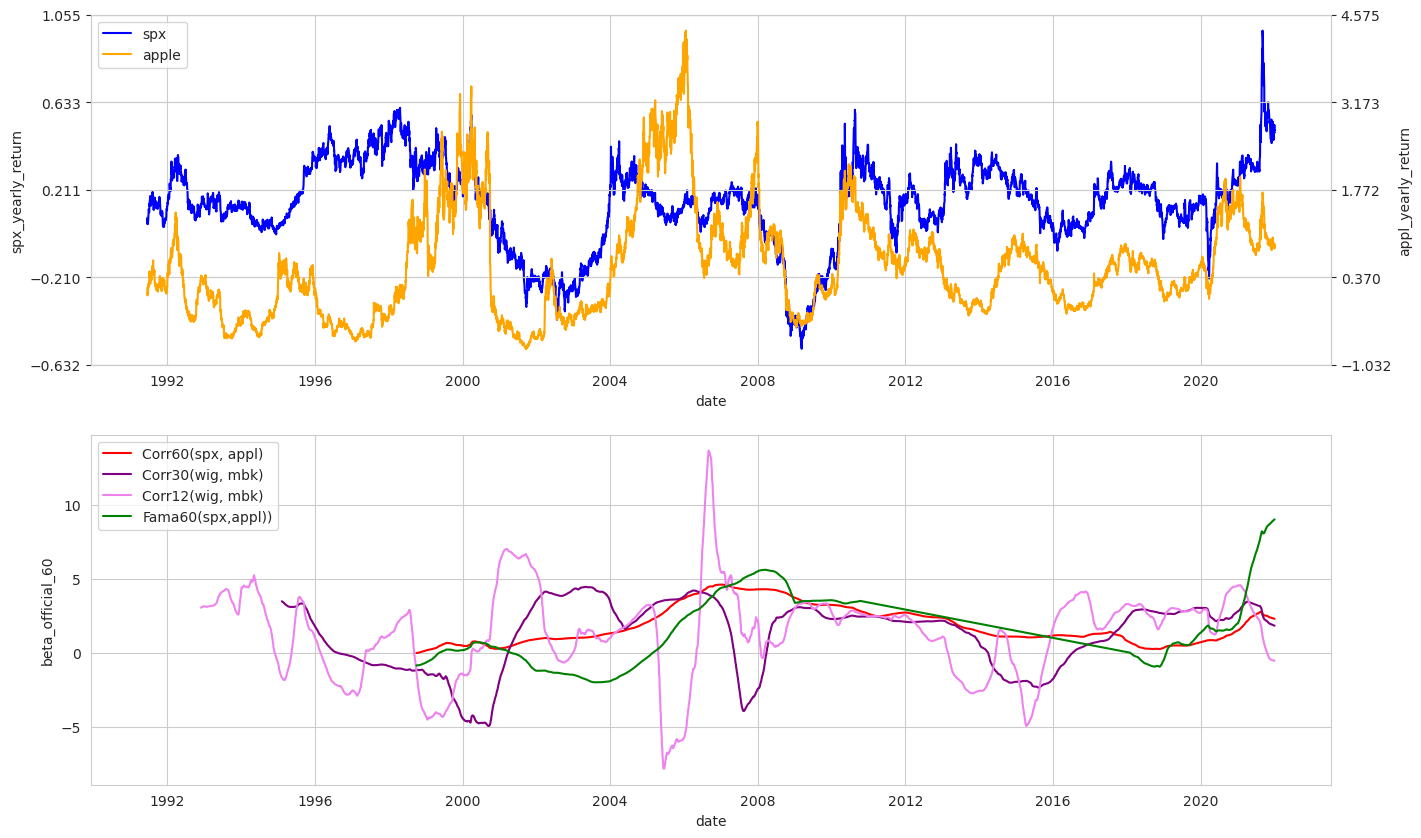

In [51]:
fig, (ax, ax2) = plt.subplots(nrows=2)

twinx = ax.twinx()

sns.lineplot(df, x='date', y='spx_yearly_return', label='spx', color='blue', ax=ax)
sns.lineplot(df, x='date', y='appl_yearly_return', label='apple', color='orange', ax=twinx)

ax_handles, ax_labels = ax.get_legend_handles_labels()
tx_handles, tx_labels = twinx.get_legend_handles_labels()
ax.legend(ax_handles + tx_handles, ax_labels + tx_labels)
twinx.get_legend().remove()

ax.set_yticks(np.linspace(ax.get_ybound()[0], ax.get_ybound()[1], 5))
twinx.set_yticks(np.linspace(twinx.get_ybound()[0], twinx.get_ybound()[1], 5))

sns.lineplot(df, x='date', y='beta_official_60', label='Corr60(spx, appl)',
             color='red', ax=ax2)
sns.lineplot(df, x='date', y='beta_official_30', label='Corr30(wig, mbk)',
             color='purple', ax=ax2)
sns.lineplot(df, x='date', y='beta_official_12', label='Corr12(wig, mbk)',
             color='violet', ax=ax2)
sns.lineplot(df, x='date', y='fama_beta', label='Fama60(spx,appl))',
             color='green', ax=ax2)


ax.get_shared_x_axes().join(ax, ax2)

fig.set_size_inches(16, 10)

In [70]:
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.ensemble import RandomForestRegressor

In [65]:
class FinancialEstimator:
    def __init__(self, sup_func):
        self._fun = sup_func

    def fit(self, *args, **kwargs):
        print(args)
        print(kwargs)
        return self

    def predict(self, X):
        print(X)
        excess_return = (X['stock_yearly_return'] - X['risk_free_return']).values.reshape(-1, 1)
        market_return = X['market_yearly_return'].values.reshape(-1, 1)
        return self._fun(excess_return, market_return)

In [85]:
est = FinancialEstimator(sup_func=fama_macbeth_beta)
forecaster = ForecasterAutoreg(
    regressor=RandomForestRegressor(n_estimators=500),
    lags=1)

In [86]:
df['datetime'] = pd.to_datetime(df['date'])
df = df.set_index('datetime')

In [87]:
df_test = df[~df['beta_official_60'].isna()]
df_test = df_test.dropna()

In [90]:
forecaster.fit(y=df_test['beta_official_60'])

/home/thmtt/miniconda3/envs/estimating-beta/lib/python3.10/site-packages/skforecast/utils/utils.py:791: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(
/home/thmtt/miniconda3/envs/estimating-beta/lib/python3.10/site-packages/skforecast/utils/utils.py:791: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(


In [89]:
df.head()

,date,value_spx,value_appl,5 Yr,year,inflation,risk_free_return,spx_yearly_return,appl_yearly_return,excess_return,beta_official_60,beta_official_30,beta_official_12,fama_beta
datetime,,,,,,,,,,,,,,
1990-01-02,1990-01-02,353.40,0.268232,7.87,1990,5.397956,2.472044,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-03,1990-01-03,359.69,0.289238,7.92,1990,5.397956,2.522044,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-04,1990-01-04,358.76,0.290992,7.91,1990,5.397956,2.512044,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-05,1990-01-05,355.67,0.287383,7.92,1990,5.397956,2.522044,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-08,1990-01-08,352.20,0.285569,7.92,1990,5.397956,2.522044,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [105]:
def build_x_y(data, input_columns, lag_size, y_col='beta'):
    X = pd.DataFrame()

    for idx, col_name in enumerate(input_columns):
        for lag_idx in range(1, lag_size+1):
            X[f'x_{idx}_{lag_idx}'] = data[col_name].shift(lag_idx)


    return X, data[y_col]

In [106]:
a = pd.DataFrame(data={
    'a': range(4),
    'b': range(5, 9)
})

In [107]:
X, y = build_x_y(a, input_columns=['a', 'b'], lag_size=2, y_col='a')

In [108]:
X.head()

,x_0_1,x_0_2,x_1_1,x_1_2
0,NaN,NaN,NaN,NaN
1,0.0,NaN,5.0,NaN
2,1.0,0.0,6.0,5.0
3,2.0,1.0,7.0,6.0


In [109]:
y.head()

0    0
1    1
2    2
3    3
Name: a, dtype: int64

In [110]:
df.head()

,date,value_spx,value_appl,5 Yr,year,inflation,risk_free_return,spx_yearly_return,appl_yearly_return,excess_return,beta_official_60,beta_official_30,beta_official_12,fama_beta
datetime,,,,,,,,,,,,,,
1990-01-02,1990-01-02,353.40,0.268232,7.87,1990,5.397956,2.472044,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-03,1990-01-03,359.69,0.289238,7.92,1990,5.397956,2.522044,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-04,1990-01-04,358.76,0.290992,7.91,1990,5.397956,2.512044,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-05,1990-01-05,355.67,0.287383,7.92,1990,5.397956,2.522044,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-08,1990-01-08,352.20,0.285569,7.92,1990,5.397956,2.522044,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [112]:
df[['date', 'risk_free_return']].to_csv('data/risk_free_us.csv', index=False)